In [20]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import MCXGate, MCMT, ZGate, XGate
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.visualization import plot_distribution

In [21]:
def oracle(marked_states):

    num_qubits = len(marked_states[0])
    qc = QuantumCircuit(num_qubits, name="U$_w$")

    for target in marked_states:
        rev_target = target[::-1]
        zero_inds = [
            ind for ind in range(num_qubits) if rev_target.startswith("0", ind)
        ]
        if len(zero_inds):
            qc.x(zero_inds)
            qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
            qc.x(zero_inds)
        else:
            qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.barrier()
    return qc

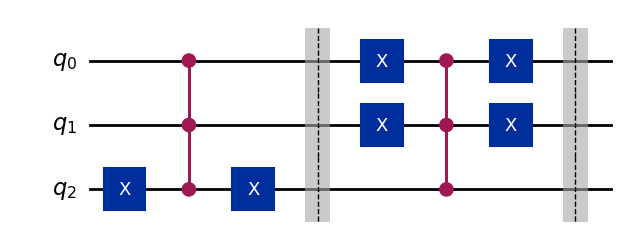

In [22]:
oracle(["011", "100"]).draw("mpl")

In [16]:
qreg = QuantumRegister(3)
qc = QuantumCircuit(qreg)
qc.h(qreg)
qc.compose(oracle(["011", "100"]), inplace=True)

sv = Statevector(qc)
sv.draw("latex")

<IPython.core.display.Latex object>

In [4]:
def diffuser(qubits):
    qreg = QuantumRegister(qubits)
    qc = QuantumCircuit(qreg, name="U$_s$")
    qc.h(qreg)
    qc.x(qreg)
    qc.barrier()
    qc.h(qubits - 1)
    ctrl_state = "1" * (qubits - 1)
    U = MCXGate(qubits - 1, ctrl_state=ctrl_state)
    qc.compose(U, inplace=True)
    qc.h(qubits - 1)
    qc.barrier()
    qc.x(qreg)
    qc.h(qreg)
    return qc

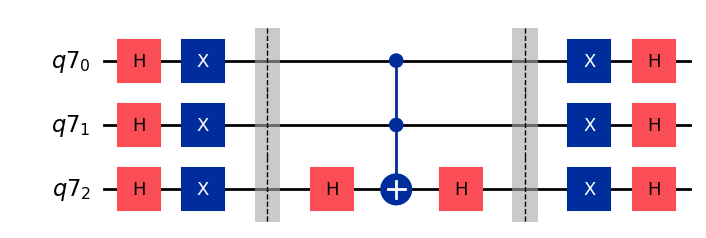

In [5]:
diffuser(3).draw("mpl")

In [6]:
def Grover(v, qubits):

    M = len(v)
    N = 2**qubits
    theta = np.arcsin(np.sqrt(M / N))
    R = int(np.floor(np.pi / (4 * theta)))

    qreg = QuantumRegister(qubits)
    creg = ClassicalRegister(qubits)
    qc = QuantumCircuit(qreg, creg)

    for i in range(qubits):
        qc.h(qreg[i])

    for _ in range(R):
        qc.compose(oracle(v), inplace=True)
        qc.compose(diffuser(qubits), inplace=True)

    qc.measure(qreg, creg)

    return qc

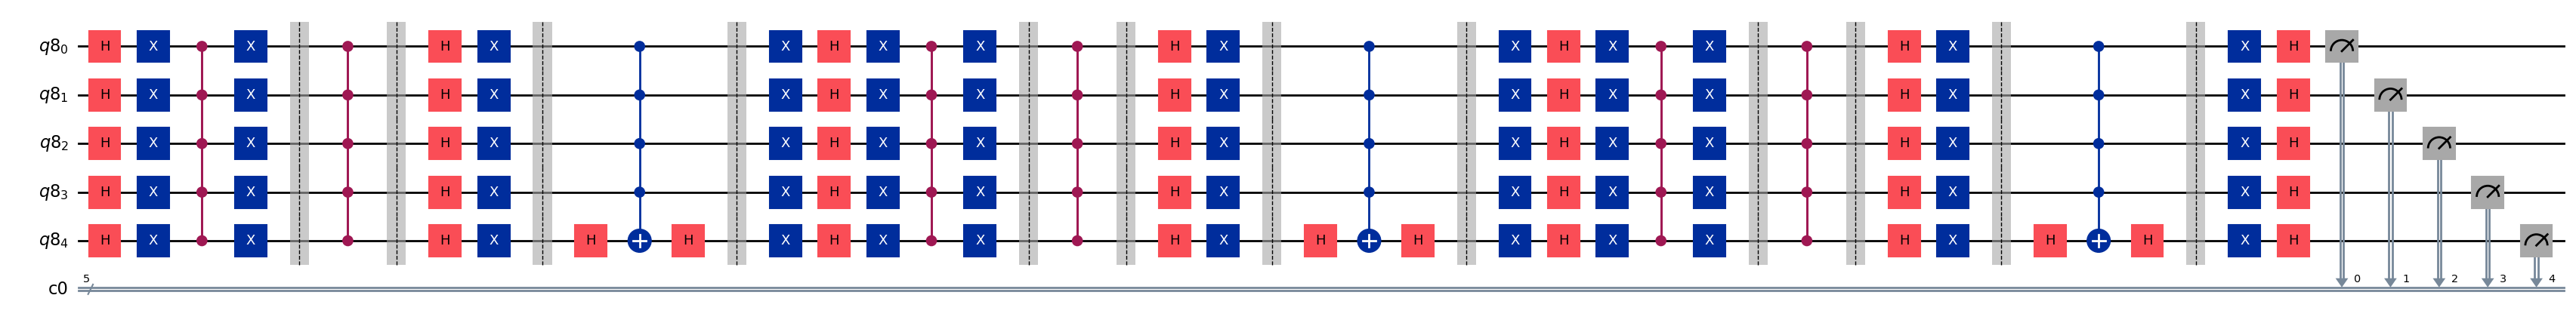

In [7]:
# qc = Grover(v=["11"], qubits=2)
# qc = Grover(v=["101", "110"], qubits=3)
qc = Grover(v=["00000", "11111"], qubits=5)
qc.draw("mpl", fold=-1)

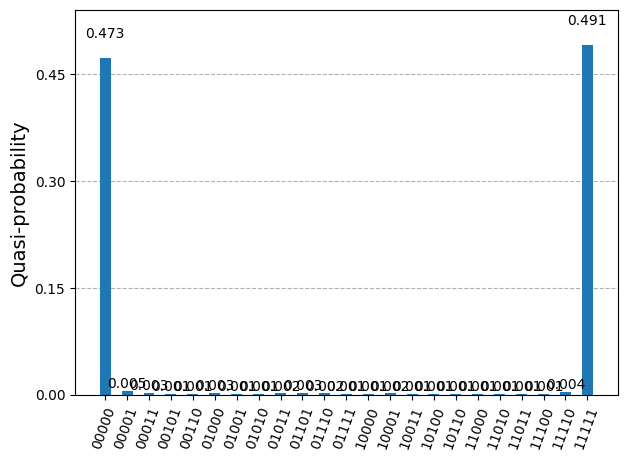

In [8]:
shots = 1024
simulator = AerSimulator()
qc = transpile(qc, simulator)
job = simulator.run(qc)
counts = job.result().get_counts(qc)
plot_distribution(counts)